In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import os
os.chdir("..")

import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, cohen_kappa_score
from multiprocessing.dummy import Pool
import pandas as pd


from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor, LBPDescriptor, DescriptorsTransformer
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesExtractor
from skin_lesion_cad.features.texture import glcm_features
from skin_lesion_cad.features.texture import get_glcm, lbph

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Counter
from sklearn.base import TransformerMixin, BaseEstimator

import scipy

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Loading feature dumps

#### Load descriptors

In [3]:
descriptors_color_train, img_classes_color_train, img_names_color_train = pd.read_pickle('descriptors_color_train_all.pkl')
descriptors_color_val, img_classes_color_val, img_names_color_val = pd.read_pickle('descriptors_color_val_all.pkl')
descriptors_color_TEST, img_classes_color_TEST, img_names_color_TEST = pd.read_pickle('descriptors_color_TESTX.pkl')

print(len(descriptors_color_train), len(descriptors_color_val), len(descriptors_color_TEST))

5082 1270 2121


## BoW Tuning

#### Checking optimal number of words on color

In [4]:
descriptors_color_train = np.asarray(descriptors_color_train)
descriptors_color_val = np.asarray(descriptors_color_val)
bow_words = [5, 8, 10, 20, 30, 50, 60, 70, 80, 100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 15000]
res = []
for nw in tqdm(bow_words):
    r = dict()
    bow_color = BagofWords(n_words=nw, n_jobs=-1, random_state=42)
    train_BoWed = bow_color.fit_transform(descriptors_color_train, img_classes_color_train) 
    val_BoWed = bow_color.transform(descriptors_color_val)

    bow_train = pd.DataFrame(train_BoWed.toarray(), columns=[f'bow_{i}' for i in range(train_BoWed.shape[1])])
    bow_val = pd.DataFrame(val_BoWed.toarray(), columns=[f'bow_{i}' for i in range(val_BoWed.shape[1])])

    bow_train['class'] = img_classes_color_train
    bow_val['class'] = img_classes_color_val

    bow_train['name'] = img_names_color_train
    bow_val['name'] = img_names_color_val


    svc = SVC(kernel='rbf', C=1, random_state=42, probability=False, class_weight='balanced')
    svc.fit(bow_train.drop(['class', 'name'], axis=1), bow_train['class'])
    y_pred = svc.predict(bow_val.drop(['class', 'name'], axis=1))
    y_pred_train = svc.predict(bow_train.drop(['class', 'name'], axis=1))

    r['cf'] = confusion_matrix(bow_val['class'], y_pred)
    r['Train f1_weighted'] = f1_score(bow_train['class'], y_pred_train, average='weighted')
    r['Validation f1_weighted'] =  f1_score(bow_val['class'], y_pred, average='weighted')
    r['Train kappa'] = cohen_kappa_score(bow_train['class'], y_pred_train)
    r['Validation kappa'] =  cohen_kappa_score(bow_val['class'], y_pred)
    
    res.append(r)

/tmp/ipykernel_89663/3112447006.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  descriptors_color_train = np.asarray(descriptors_color_train)
/tmp/ipykernel_89663/3112447006.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  descriptors_color_val = np.asarray(descriptors_color_val)
  0%|          | 0/25 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
rr = pd.DataFrame(res, index=bow_words)
rr.to_csv('bow_color_numOFwords.csv')
# rr = pd.read_csv('bow_color_numOFwords.csv', index_col=0)
rr

,cf,Train f1_weighted,Validation f1_weighted,Train kappa,Validation kappa
5,[[324 174 0]\n [140 538 0]\n [ 57 37 0]],0.670780,0.651905,0.424521,0.387242
8,[[349 149 0]\n [147 531 0]\n [ 55 39 0]],0.688920,0.666758,0.461281,0.417993
10,[[383 115 0]\n [172 506 0]\n [ 59 35 0]],0.702550,0.675111,0.491383,0.438900
20,[[379 119 0]\n [146 532 0]\n [ 62 32 0]],0.713621,0.691305,0.511781,0.468303
30,[[381 117 0]\n [125 553 0]\n [ 61 33 0]],0.726855,0.708114,0.536626,0.500269
50,[[394 103 1]\n [130 548 0]\n [ 57 32 5]],0.755602,0.723684,0.584986,0.522969
60,[[388 108 2]\n [121 556 1]\n [ 63 28 3]],0.758916,0.722145,0.591957,0.522069
70,[[394 104 0]\n [128 550 0]\n [ 58 35 1]],0.761965,0.717782,0.598963,0.518279
80,[[397 100 1]\n [127 551 0]\n [ 64 29 1]],0.768700,0.721454,0.611461,0.525329
100,[[399 98 1]\n [126 552 0]\n [ 63 26 5]],0.785625,0.730826,0.638138,0.536940


In [1]:
rr[['Train kappa', 'Validation kappa']].sort_values(['Validation kappa']).plot.bar()
plt.xlabel('Number of words')
plt.ylabel('Kappa')

NameError: name 'rr' is not defined

### Testing color BoW

In [5]:
descriptors_color_train = np.asarray(descriptors_color_train)
descriptors_color_val = np.asarray(descriptors_color_val)


bow_color = BagofWords(n_words=100, n_jobs=-1, random_state=42)
train_BoWed = bow_color.fit_transform(descriptors_color_train, img_classes_color_train) 
val_BoWed = bow_color.transform(descriptors_color_val)

bow_train = pd.DataFrame(train_BoWed.toarray(), columns=[f'bow_{i}' for i in range(train_BoWed.shape[1])])
bow_val = pd.DataFrame(val_BoWed.toarray(), columns=[f'bow_{i}' for i in range(val_BoWed.shape[1])])

bow_train['class'] = img_classes_color_train
bow_val['class'] = img_classes_color_val

bow_train['name'] = img_names_color_train
bow_val['name'] = img_names_color_val


svc = SVC(kernel='rbf', C=1, random_state=42, probability=False, class_weight='balanced')
svc.fit(bow_train.drop(['class', 'name'], axis=1), bow_train['class'])
y_pred = svc.predict(bow_val.drop(['class', 'name'], axis=1))
y_pred_train = svc.predict(bow_train.drop(['class', 'name'], axis=1))

print(confusion_matrix(bow_val['class'], y_pred))
print('Train f1_weighted',f1_score(bow_train['class'], y_pred_train, average='weighted'))
print('Validation f1_weighted', f1_score(bow_val['class'], y_pred, average='weighted'))
print('Train kappa',cohen_kappa_score(bow_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(bow_val['class'], y_pred))

[[549 128   1]
 [ 92 405   1]
 [ 34  60   0]]
Train f1_weighted 0.7814170329131336
Validation f1_weighted 0.7243712470219058
Train kappa 0.6368262876137128
Validation kappa 0.5332120574866124


# Feature selection

In [6]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder


In [7]:
merged_df_val = pd.read_pickle('merged_df_val.pkl')
merged_df_train = pd.read_pickle('merged_df_train.pkl')
merged_df_TEST = pd.read_pickle('merged_df_TEST.pkl')

Get a dict with all column names by feature group (just in case)

In [8]:
def check_subst_list(list_str, check_str):
    for l in list_str:
        if l in check_str:
            return True
    return False

feature_classes = {'color':[x for x in merged_df_train.columns if check_subst_list(['bgr', 'hsv', 'YCrCb'],x)],
                   'glcm':[x for x in merged_df_train.columns if check_subst_list(['contrast', 'dissimilarity',
                                                                                   'homogeneity', 'energy',
                                                                                   'correlation', 'ASM'], x)], 
                   'lbp': [x for x in merged_df_train.columns if 'lbp' in x], 
                   'bow':[x for x in merged_df_train.columns if 'bow' in x]}

In [9]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])
y_train = merged_df_train['class']
y_test = merged_df_val['class']


scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)
svc = SVC(kernel='rbf', C=8, probability=False, class_weight='balanced')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy',balanced_accuracy_score(merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))

(5082, 442) (1270, 442)
[[622  50   6]
 [ 42 444  12]
 [ 15  32  47]]
Balanced accuracy 0.919104129243888
Balanced accuracy 0.7696567982845837
Train kappa 0.943603151204374
Validation kappa 0.7745681078147613


### Feature Importances

In [10]:
clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0, class_weight='balanced')

cols =  merged_df_train.drop(columns=['class']).columns
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy',balanced_accuracy_score(merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))


output = cross_validate(clf, X_train, y_train, cv=10, scoring = 'balanced_accuracy', return_estimator =True)
feature_importances = []
for idx,estimator in enumerate(output['estimator']):
    feature_importances.append(pd.DataFrame(estimator.feature_importances_,
                                       index = cols,
                                        columns=['importance']).sort_values('importance', ascending=False))


[[493  82 103]
 [ 36 321 141]
 [  8  18  68]]
Balanced accuracy 0.8598002632369989
Balanced accuracy 0.6983737372133358
Train kappa 0.6891712194283821
Validation kappa 0.512035713012513


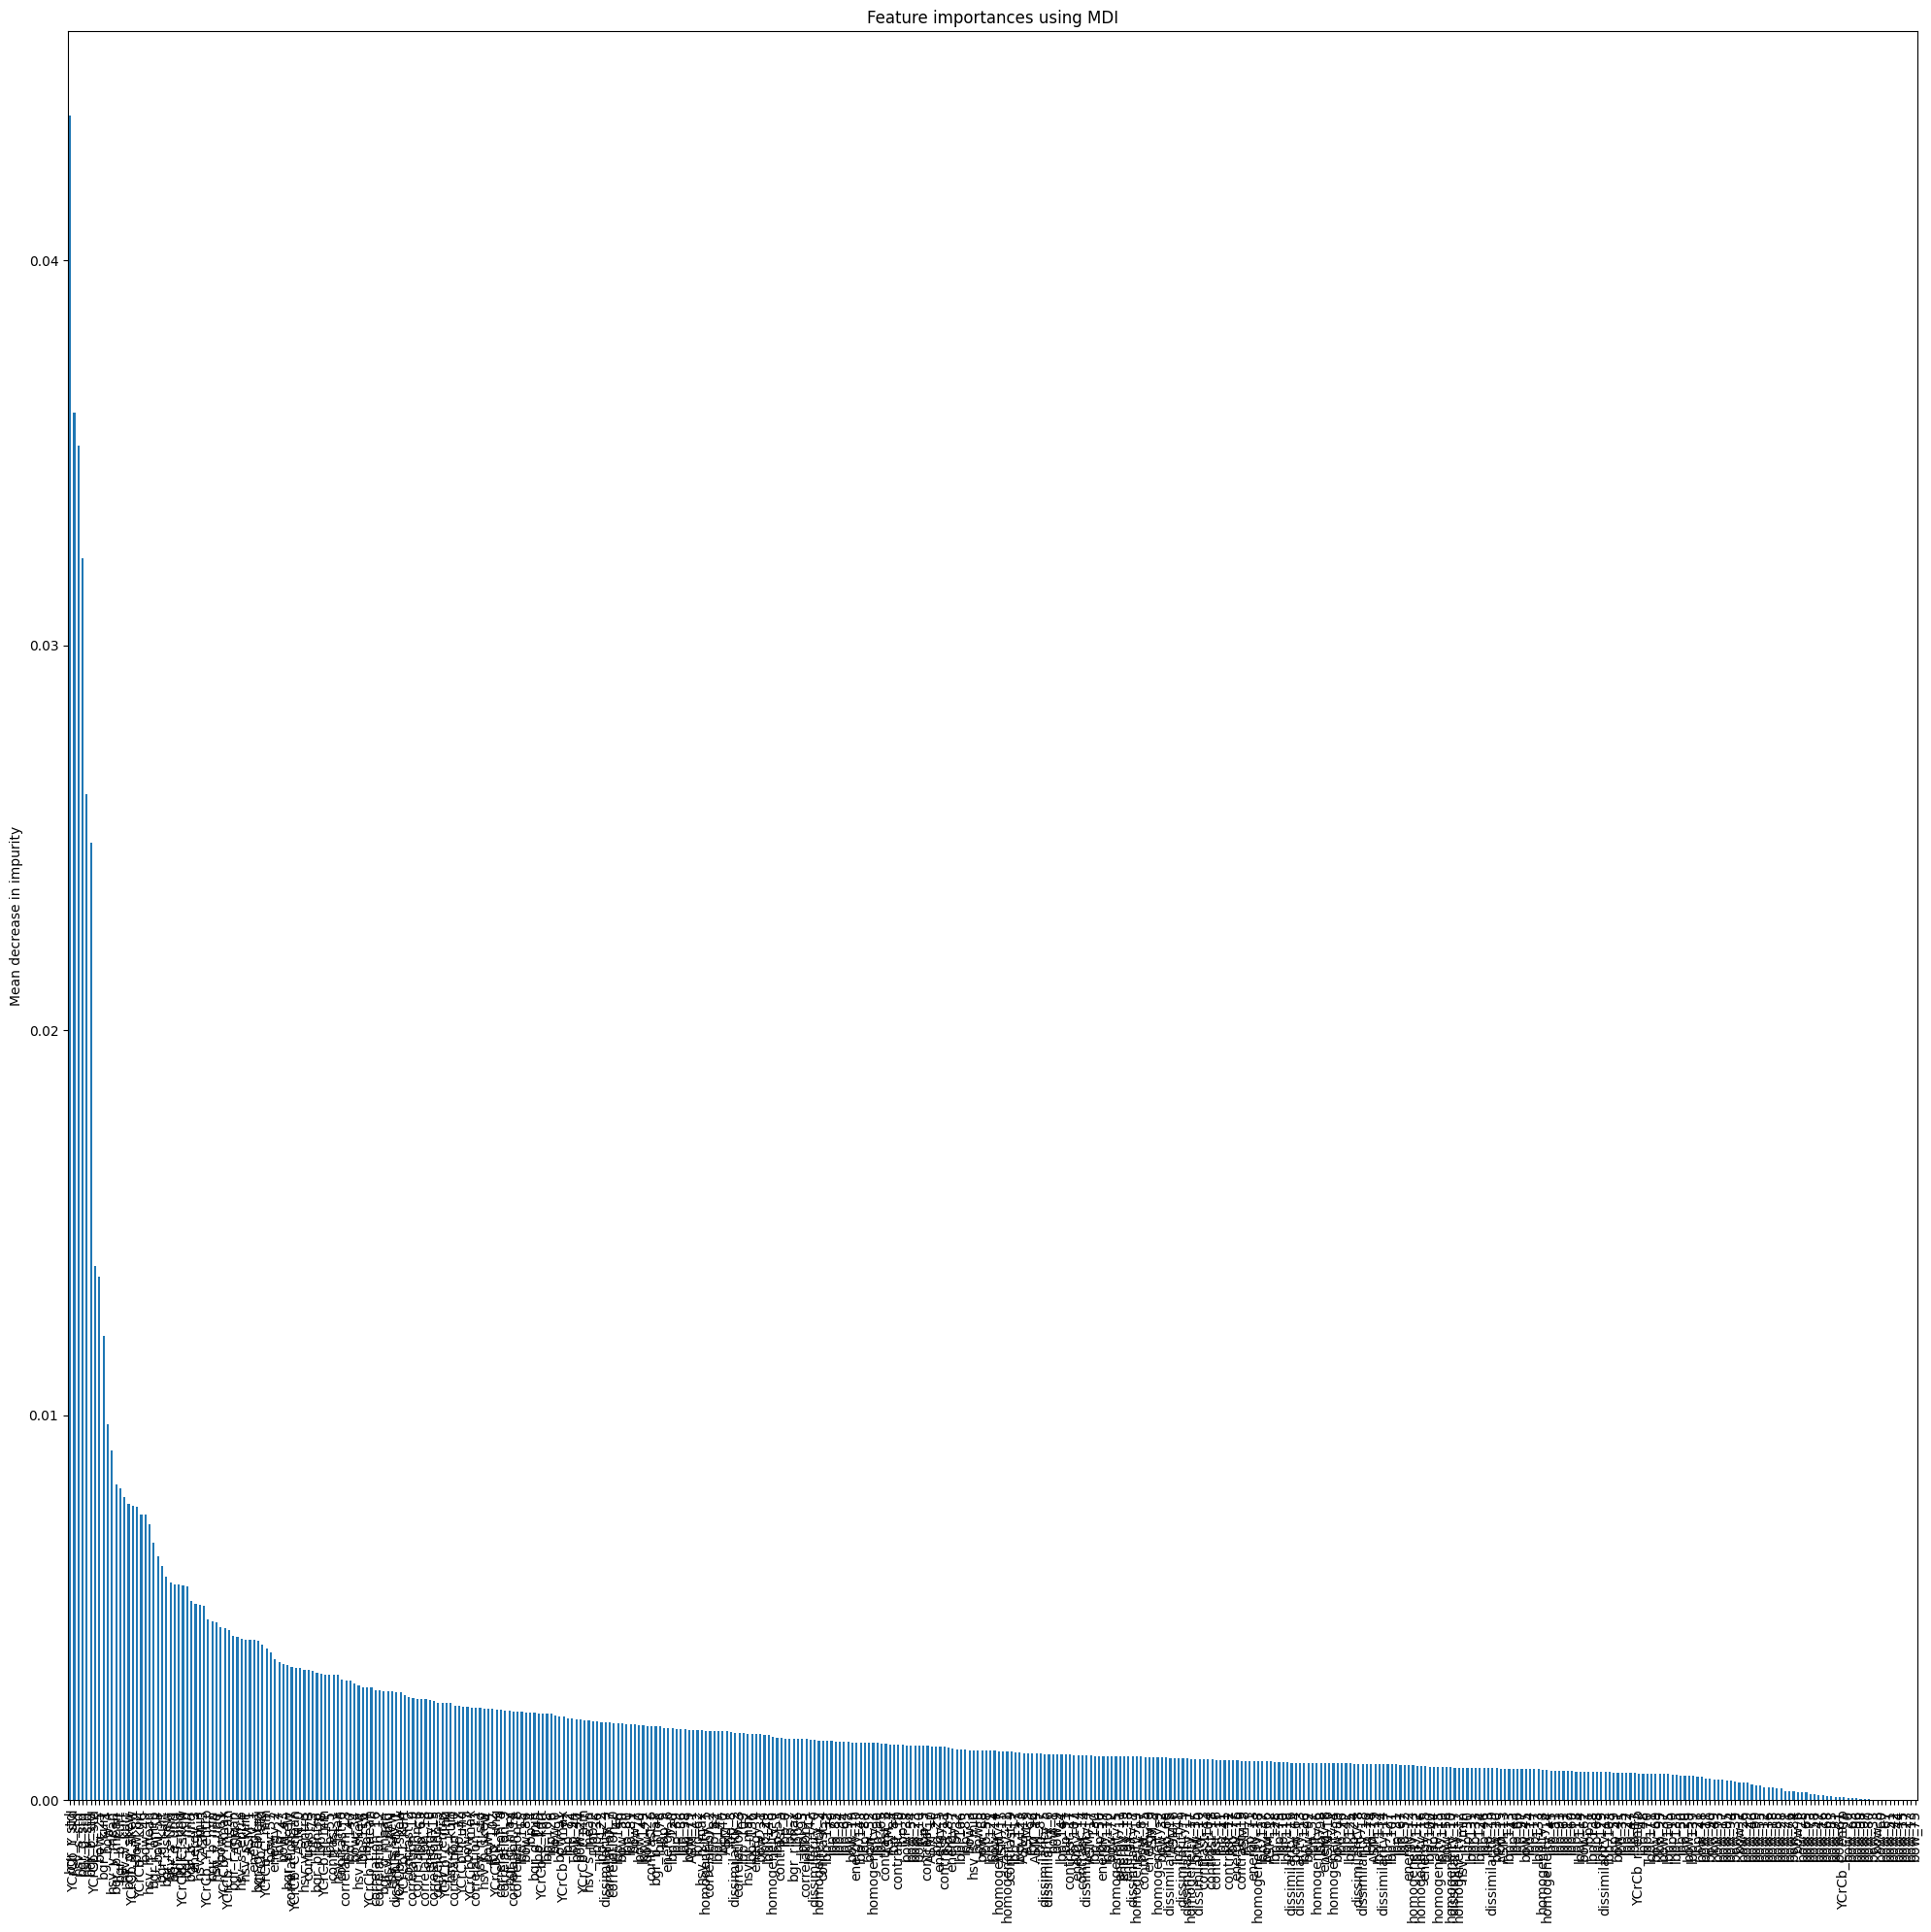

In [11]:
fi_res = pd.concat(feature_importances, axis=1).mean(axis=1).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(20, 20))
fi_res.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [1]:
feature_importances_groupped = {k:0 for k in feature_classes.keys()}
feature_classes_inverted = {v:k for k,vv in feature_classes.items() for v in vv}

for fet, count in Counter(fi_res.index[:int(len(fi_res)*0.2)]).items():
    feature_importances_groupped[feature_classes_inverted[fet]] += count
# normalize
feature_importances_groupped = {k:v/sum(feature_importances_groupped.values()) for k,v in feature_importances_groupped.items()}
sns.barplot(x=list(feature_importances_groupped.keys()), y=list(feature_importances_groupped.values()))
plt.xlabel('Feature type')
plt.ylabel('Percentage of features from top 20%')

NameError: name 'feature_classes' is not defined

In [13]:
top_features = fi_res.index[:int(len(fi_res)*0.2)]

X_train = merged_df_train.drop(columns=['class'])[top_features]
X_test = merged_df_val.drop(columns=['class'])[top_features]
y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy',balanced_accuracy_score(merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))

(5082, 88) (1270, 88)
[[626  48   4]
 [ 41 444  13]
 [ 16  38  40]]
Balanced accuracy 0.8629409680423611
Balanced accuracy 0.7468006715873726
Train kappa 0.8969369907164899
Validation kappa 0.7692293714680283


In [14]:
top_features

Index(['bgr_r_std', 'YCrCb_Y_std', 'hsv_s_std', 'bgr_g_std', 'hsv_v_std',
       'bgr_b_std', 'YCrCb_C_std', 'bow_25', 'bgr_r_kurt', 'bow_4',
       'hsv_v_mean', 'bgr_b_mean', 'bgr_b_kurt', 'hsv_v_kurt', 'bgr_g_skew',
       'YCrCb_Y_skew', 'bow_82', 'YCrCb_Y_kurt', 'bow_49', 'hsv_h_mean',
       'bgr_r_entrp', 'bow_53', 'bgr_g_kurt', 'bgr_r_skew', 'hsv_s_unq',
       'bgr_g_unq', 'bgr_r_unq', 'YCrCb_C_skew', 'bgr_r_min', 'bgr_b_unq',
       'energy_3', 'hsv_v_min', 'ASM_3', 'YCrCb_Y_entrp', 'bgr_b_min',
       'hsv_v_unq', 'bow_61', 'YCrCb_r_max', 'YCrCb_Y_mean', 'bgr_r_mean',
       'ASM_2', 'hsv_s_entrp', 'hsv_s_kurt', 'ASM_1', 'energy_1',
       'bgr_g_entrp', 'YCrCb_r_std', 'YCrCb_C_min', 'bow_57', 'energy_2',
       'lbp_27', 'bow_43', 'bgr_b_skew', 'correlation_17', 'YCrCb_C_mean',
       'ASM_0', 'hsv_v_entrp', 'contrast_3', 'lbp_73', 'bgr_b_entrp', 'lbp_28',
       'YCrCb_Y_min', 'lbp_55', 'contrast_1', 'hsv_s_max', 'contrast_0',
       'correlation_13', 'lbp_140', 'bow_34', 

### PCA

In [15]:
comp = [5, 10, 20, 40, 60, 80, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 230, 250, 270, 300, 330, 350]

test_kappa = []
train_kappa = []
var_expl = []
for c in tqdm(comp):
    pca = PCA(n_components=c)


    X_train = merged_df_train.drop(columns=['class'])
    X_test = merged_df_val.drop(columns=['class'])



    y_train = merged_df_train['class']
    y_test = merged_df_val['class']

    scaler = DescriptorsTransformer(None)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Apply PCA
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)


    # print(X_train.shape, X_test.shape)

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_pred_train = svc.predict(X_train)

    # print(confusion_matrix(merged_df_val['class'], y_pred))
    # print('Balanced accuracy',balanced_accuracy_score(merged_df_train['class'], y_pred_train))
    # print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
    # print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
    # print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))
    test_kappa.append(cohen_kappa_score(merged_df_val['class'], y_pred))
    train_kappa.append(cohen_kappa_score(merged_df_train['class'], y_pred_train))
    var_expl.append(pca.explained_variance_ratio_.sum())


100%|██████████| 23/23 [00:10<00:00,  2.24it/s]


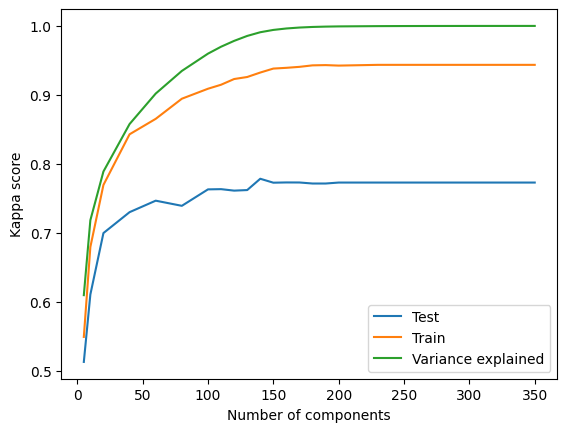

In [16]:
plt.plot(comp, test_kappa)
plt.plot(comp, train_kappa)
plt.plot(comp, var_expl)
plt.xlabel('Number of components')
plt.ylabel('Kappa score')
plt.legend(['Test', 'Train', 'Variance explained'])
plt.show()


In [17]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])



y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


print(X_train_pca.shape, X_test_pca.shape)

svc.fit(X_train_pca, y_train)
y_pred = svc.predict(X_test_pca)
y_pred_train = svc.predict(X_train_pca)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy',balanced_accuracy_score(merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))

(5082, 150) (1270, 150)
[[623  50   5]
 [ 44 442  12]
 [ 15  32  47]]
Balanced accuracy 0.9118267600862048
Balanced accuracy 0.7688097522834703
Train kappa 0.9382092702329734
Validation kappa 0.7728898426323318


### SMOTE

In [18]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import fbeta_score, make_scorer

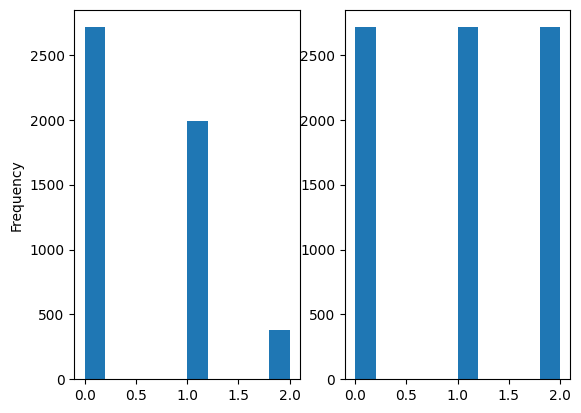

In [19]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
plt.subplot(1,2,1)
merged_df_train['class'].plot.hist()
# plt.show()
plt.subplot(1,2,2)
plt.hist(y_res)
plt.show()

In [20]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])



y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1, sampling_strategy='not majority') 
X_train, y_train = sm.fit_resample(X_train, y_train)


print(X_train.shape, X_test.shape)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced train accuracy',balanced_accuracy_score(y_train, y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
print('Train kappa',cohen_kappa_score(y_train, y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))

(8139, 442) (1270, 442)
[[623  42  13]
 [ 41 435  22]
 [ 12  26  56]]
Balanced train accuracy 0.9917680304705737
Balanced accuracy 0.7960392376006253
Train kappa 0.9876520457058606
Validation kappa 0.7787663982204832


## Grid Search

In [21]:
scoring = 'kappa'

gs_results = {'rf_fs':dict(), 'pca':dict(), 'smote':dict(), 'full':dict()}

models = {'svc':{'model':SVC(),
                 'param_dict':{'kernel':['rbf'],
                               'C':[1, 10, 0.1, 20, 100, 1000],
                               'class_weight':['balanced', None],
                               'gamma':[0.1, 1, 10, 100]}},
          
          
          'rf':{'model':RandomForestClassifier(),
                 'param_dict':{'bootstrap': [True, False],
                               'max_depth': [10, 20, 40, 80, 100, None]}}}
          
for data_prepr in gs_results.keys():
    
    # load data
    X_train = merged_df_train.drop(columns=['class'])
    X_test = merged_df_val.drop(columns=['class'])
    y_train = merged_df_train['class']
    y_test = merged_df_val['class']

    scaler = DescriptorsTransformer(None)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Apply data preprocessing
    
    if data_prepr == 'pca':
        # Apply PCA
        pca = PCA(n_components=150)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    
    
    elif data_prepr == 'smote':
        sm = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1, sampling_strategy='not majority') 
        X_train, y_train = sm.fit_resample(X_train, y_train)
        
    elif data_prepr == 'rf_fs':
        
        top_features = fi_res.index[:int(len(fi_res)*0.2)]

        X_train = merged_df_train.drop(columns=['class'])[top_features]
        X_test = merged_df_val.drop(columns=['class'])[top_features]
        y_train = merged_df_train['class']
        y_test = merged_df_val['class']

        scaler = DescriptorsTransformer(None)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
    if scoring == 'kappa':
        scoring = make_scorer(cohen_kappa_score)
    for model, mpar in models.items():
        clf = GridSearchCV(mpar['model'],
                           mpar['param_dict'],
                           scoring=scoring, 
                           cv=5, n_jobs=-1,
                           verbose = 0)
        clf.fit(X_train, y_train)
        
        best_est = clf.best_estimator_
        best_est.fit(X_train, y_train)
        y_pred = best_est.predict(X_test)
        y_pred_train = best_est.predict(X_train)     
        
        gs_results[data_prepr][model] = dict()
        gs_results[data_prepr][model]['metric'] = 'kappa'
        gs_results[data_prepr][model]['gridsearch'] = clf
        gs_results[data_prepr][model]['best_estimator_'] = clf.best_estimator_
        gs_results[data_prepr][model]['best_score_'] = clf.best_score_
        gs_results[data_prepr][model]['best_params_'] = clf.best_params_
        gs_results[data_prepr][model]['best_estimator_'] = clf.best_estimator_
        
        gs_results[data_prepr][model]['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        gs_results[data_prepr][model]['train_balanced_accuracy_score'] = balanced_accuracy_score(y_train, y_pred_train)
        gs_results[data_prepr][model]['test_balanced_accuracy_score'] = balanced_accuracy_score(y_test, y_pred)
        gs_results[data_prepr][model]['train_cohen_kappa_score'] = cohen_kappa_score(y_train, y_pred_train)
        gs_results[data_prepr][model]['test_cohen_kappa_score'] = cohen_kappa_score(y_test, y_pred)

/home/vzalevskyi/anaconda3/envs/cad/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/vzalevskyi/anaconda3/envs/cad/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/vzalevskyi/anaconda3/envs/cad/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [22]:
gs_results = dict()
gs_results_kappa = {'svc':pd.read_pickle('gs_results_kappa_svc.pkl'),
                    'rf':pd.read_pickle('gs_results_kappa_rf.pkl')}

gs_results_balacc = {'svc':pd.read_pickle('gs_results_balacc_svc.pkl'),
                    'rf':pd.read_pickle('gs_results_balacc_rf.pkl')}

In [37]:
flattened_kappa_res = []

for est in gs_results_kappa.keys():
    for data in gs_results_kappa[est].keys():
        r = {k:v for k,v in gs_results_kappa[est][data][est].items()}
        r['estimator_class'] = est
        r['data'] = data
        flattened_kappa_res.append(r)

kappa_res_df = pd.DataFrame(flattened_kappa_res)
kappa_res_df = kappa_res_df.sort_values(by=['test_cohen_kappa_score'])
kappa_res_df

,metric,gridsearch,best_estimator_,best_score_,best_params_,confusion_matrix,train_balanced_accuracy_score,test_balanced_accuracy_score,train_cohen_kappa_score,test_cohen_kappa_score,estimator_class,data
3,kappa,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.025460,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[17, 481, 0], [0, 678, 0], [0, 93, 1]]",1.0,0.348258,1.0,0.035082,svc,full
1,kappa,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.038848,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[24, 474, 0], [0, 678, 0], [0, 92, 2]]",1.0,0.356490,1.0,0.050847,svc,pca
2,kappa,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.641735,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[27, 471, 0], [0, 678, 0], [0, 91, 3]]",1.0,0.362044,1.0,0.058952,svc,smote
5,kappa,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=40, max_feat...",0.615428,"{'bootstrap': False, 'max_depth': 40}","[[401, 96, 1], [76, 602, 0], [52, 33, 9]]",1.0,0.596290,1.0,0.615828,rf,pca
0,kappa,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.660593,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[410, 82, 6], [39, 638, 1], [34, 34, 26]]",1.0,0.680297,1.0,0.709901,svc,rf_fs
4,kappa,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=20, max_feat...",0.698690,"{'bootstrap': False, 'max_depth': 20}","[[432, 61, 5], [52, 625, 1], [45, 30, 19]]",1.0,0.663809,1.0,0.714064,rf,rf_fs
7,kappa,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=20, max_feat...",0.694142,"{'bootstrap': False, 'max_depth': 20}","[[434, 61, 3], [49, 627, 2], [47, 26, 21]]",1.0,0.673223,1.0,0.723152,rf,full
6,kappa,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=80, max_feat...",0.888688,"{'bootstrap': False, 'max_depth': 80}","[[427, 54, 17], [64, 604, 10], [28, 19, 47]]",1.0,0.749428,1.0,0.725553,rf,smote


In [38]:
flattened_balacc_res = []

for est in gs_results_balacc.keys():
    for data in gs_results_balacc[est].keys():
        r = {k:v for k,v in gs_results_balacc[est][data][est].items()}
        r['estimator_class'] = est
        r['data'] = data
        flattened_balacc_res.append(r)

balacc_res_df = pd.DataFrame(flattened_balacc_res)
balacc_res_df= balacc_res_df.sort_values(by=['test_cohen_kappa_score'])
balacc_res_df

,metric,gridsearch,best_estimator_,best_score_,best_params_,confusion_matrix,train_balanced_accuracy_score,test_balanced_accuracy_score,train_cohen_kappa_score,test_cohen_kappa_score,estimator_class,data
3,balanced_accuracy,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.342197,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[17, 481, 0], [0, 678, 0], [0, 93, 1]]",1.0,0.348258,1.0,0.035082,svc,full
1,balanced_accuracy,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.346881,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[24, 474, 0], [0, 678, 0], [0, 92, 2]]",1.0,0.356490,1.0,0.050847,svc,pca
2,balanced_accuracy,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.761124,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[27, 471, 0], [0, 678, 0], [0, 91, 3]]",1.0,0.362044,1.0,0.058952,svc,smote
5,balanced_accuracy,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=40, max_feat...",0.580964,"{'bootstrap': False, 'max_depth': 40}","[[408, 90, 0], [81, 597, 0], [44, 39, 11]]",1.0,0.605610,1.0,0.622362,rf,pca
0,balanced_accuracy,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.630521,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[410, 82, 6], [39, 638, 1], [34, 34, 26]]",1.0,0.680297,1.0,0.709901,svc,rf_fs
4,balanced_accuracy,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=80, max_feat...",0.648579,"{'bootstrap': False, 'max_depth': 80}","[[430, 62, 6], [53, 623, 2], [46, 27, 21]]",1.0,0.668579,1.0,0.711897,rf,rf_fs
7,balanced_accuracy,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=80, max_feat...",0.636460,"{'bootstrap': False, 'max_depth': 80}","[[433, 60, 5], [51, 626, 1], [46, 26, 22]]",1.0,0.675608,1.0,0.722056,rf,full
6,balanced_accuracy,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=40, max_feat...",0.926395,"{'bootstrap': False, 'max_depth': 40}","[[428, 52, 18], [62, 607, 9], [25, 21, 48]]",1.0,0.755119,1.0,0.732659,rf,smote


In [35]:
kappa_res_df.iloc[7]

metric                                                                       kappa
gridsearch                       GridSearchCV(cv=5, estimator=RandomForestClass...
best_estimator_                  (DecisionTreeClassifier(max_depth=80, max_feat...
best_score_                                                               0.888688
best_params_                                 {'bootstrap': False, 'max_depth': 80}
confusion_matrix                      [[427, 54, 17], [64, 604, 10], [28, 19, 47]]
train_balanced_accuracy_score                                                  1.0
test_balanced_accuracy_score                                              0.749428
train_cohen_kappa_score                                                        1.0
test_cohen_kappa_score                                                    0.725553
estimator_class                                                                 rf
data                                                                         smote
Name

## Best classifiers:
* RandomForestClassifier(bootstrap=False, max_depth=40) -> full, test_cohen_kappa_score                                                    0.709901

```
[[428, 52, 18]
[62, 607, 9]
[25, 21, 48]]
```

* SVC(C=10, class_weight='balanced', gamma=0.1) -> rf_fs test_cohen_kappa_score                                                    0.732659

```
 [[410, 82, 6]
 [39, 638, 1]
 [34, 34, 26]]
 ```

 * RandomForestClassifier(bootstrap=False, max_depth=80) -> smote + full, test_cohen_kappa_score                                                    0.725553

```
 [[427, 54, 17]
 [64, 604, 10]
 [28, 19, 47]]
```

* SVC(kernel='rbf', C=8, random_state=42, probability=False, class_weight='balanced') -> full -> 76 kappa